In [ ]:
# https://github.com/ViktorKumpan/DeepLearning_MRI_BRATS/blob/master/Classification_MRI.ipynb

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torchio

     |████████████████████████████████| 156 kB 5.2 MB/s 
     |████████████████████████████████| 48.4 MB 32 kB/s 


In [ ]:
import numpy as np
import os
import pandas as pd
#!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from torch.hub import load_state_dict_from_url

from torch.optim import lr_scheduler

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import matplotlib as plt
import seaborn as sns
from skimage import io
device = torch.device("cuda:0")
import torchio as tio
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix,jaccard_score, accuracy_score,f1_score,average_precision_score
from PIL import Image
from skimage import io, transform
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import torchvision
from sklearn.model_selection import train_test_split

In [ ]:
path_to_HGG = "/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training/HGG"
path_to_LGG = "/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training/LGG"
root_dir = "/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training"
name_map = {"train":"Train_DS.csv","test":"Test_DS.csv"}
path_to_survival = "/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training/survival_data.csv"
types_file = ["_flair.nii","_t1.nii","_t1ce.nii","_t2.nii"]

In [ ]:
root_dir='/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training'
df = pd.read_csv("/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/MICCAI_BraTS_2019_Data_Training/name_mapping.csv",delimiter=',')
df=df.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID'], axis=1)
df=df.dropna()
hgg_df=df[df['Grade']=='HGG']
lgg_df=df[df['Grade']=='LGG']
sam_hgg_df=hgg_df.sample(76,random_state=10)
sam_lgg_df=lgg_df.sample(76,random_state=10)
df=pd.concat([sam_hgg_df, sam_lgg_df])
df=df.sample(frac=1)
df.to_csv('df.csv')

In [ ]:
test_data=df.sample(frac=0.2, random_state=10)
test_data.to_csv('Test_DS.csv')
test_data.groupby(['Grade']).count()

,BraTS_2019_subject_ID
Grade,
HGG,16
LGG,14


In [ ]:
test_data=pd.concat([df, test_data, test_data]).drop_duplicates(keep=False)
test_data.to_csv('Train_DS.csv')
test_data.groupby(['Grade']).count()

,BraTS_2019_subject_ID
Grade,
HGG,60
LGG,62


In [ ]:
def plot_class_histogram(markup_map, title=None):
    ax = sns.catplot(x='Grade', data=markup_map, kind="count", palette="ch:.25")
    ax.fig.suptitle(title)
    ax.fig.set_size_inches(10,5)

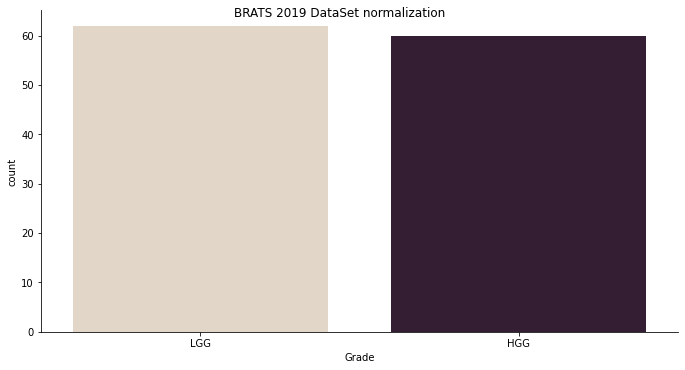

In [ ]:
plot_class_histogram(test_data, title='BRATS 2019 DataSet normalization')

In [ ]:
class BratsDataset(Dataset):
    
    def __init__(self, csv_file , root_dir,types_file, transform=None):
        self.labels_frame = pd.read_csv(csv_file,delimiter=',')
        self.root_dir = root_dir
        self.transform = transform
        self.types_file = types_file
        
    def __len__(self):
        return len(self.labels_frame)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        img_name = os.path.join('/content/gdrive/MyDrive/NUS_GAIP_GRP9/dataset/BRATS/',self.root_dir, self.labels_frame.iloc[idx,1],self.labels_frame.iloc[idx,2],
                                "{}{}".format(self.labels_frame.iloc[idx,2],self.types_file))
        img = nib.load(img_name)
        img = np.array(img.dataobj)
        img = torch.from_numpy(img)
        img = img.unsqueeze(0)
        img = img.type(torch.FloatTensor)
        
        label = self.labels_frame.iloc[idx, 1]
           
        label = 0 if label == "HGG" else 1
        label = np.array([label])
        label = torch.from_numpy(label)
        label = label.type(torch.LongTensor)
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [ ]:
print(len(test_data[test_data["Grade"] == "HGG"]), len(test_data[test_data["Grade"] == "LGG"]))

60 62


In [ ]:
transform=transforms.Compose(
        [
            
            lambda x: (x-x.min())/(x.max()-x.min()), #2*((x-x.min())/(x.max()-x.min())) - 1,
            #lambda x: x[np.newaxis, :, :, :],
            lambda x: x.clone().detach(),
            #lambda x: torch.tensor(x, dtype=torch.float32),
#           
        ]
    )

In [ ]:
brain_train = BratsDataset(csv_file = name_map["train"],root_dir = root_dir,types_file = types_file[0],transform=transform)
brain_test = BratsDataset(csv_file = name_map["test"],root_dir = root_dir,types_file = types_file[0],transform=transform)

In [ ]:
len(brain_train)

122

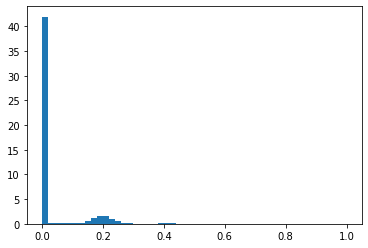

In [ ]:
plt.hist(np.array(brain_train[90][0]).ravel(), bins=50, density=True);

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    view(image[0,:,:,:])
    plt.figure(figsize=(30, 3))
    plt.subplot(1, 1,1)
    plt.grid(False)
    plt.imshow(image[0,:,:,95])
    plt.axis('off')
    print(landmarks)

In [ ]:
def sempler(data_train, batch_size = 4,split = .25):
    
    data_size = len(data_train)

    validation_split = split
    split = int(np.floor(validation_split * data_size))
    indices = list(range(data_size))
    np.random.shuffle(indices)

    train_indices,val_indices = indices[split:],indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                   sampler=train_sampler,)
    
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                 sampler=val_sampler,)

    return train_loader,val_loader

In [ ]:
train_loader, val_loader = sempler(brain_train, split=0.25)
test_loader = torch.utils.data.DataLoader(brain_test, batch_size=4,
                                                   shuffle=True)
print(len(test_loader))

8


In [ ]:
import gc

def train_model(model,train_loader,val_loader,loss,optimizer, num_epochs,writer):
    loss_history = []
    train_history = []
    val_history = []
    val_loss_hist = []
    metric_y_val = metric_p_val = None
    
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                  T_0=40, 
                                                  T_mult=2,
                                                  eta_min=1e-9)
    for epoch in range(num_epochs):
        
        print(epoch)
        model.train()
        
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        for i_step, (x, y) in enumerate(train_loader):
                
                x_gpu = x.to(device=device)
                y_gpu = y.to(device=device)
                
                prediction = model(x_gpu)
                loss_value = loss(prediction, y_gpu.reshape((-1,)))
                _, preds = torch.max(prediction, 1)
                

                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()
                
                
                if i_step == 0 and epoch == 0:
                    metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                    metric_p = preds.cpu().numpy()
                else:
                    metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                    metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
                    
                correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
                loss_accum += loss_value
                
                total_samples += y_gpu.shape[0]
                del x_gpu
                del y_gpu
                #gc.collect()
        
        
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = correct_samples / total_samples
        writer.add_scalar("Loss/train", ave_loss, epoch)
        writer.add_scalar("Acc/train", train_accuracy, epoch)
        writer.add_scalar("F1/train", f1_score(metric_y,metric_p), epoch)

        val_accuracy, loss_val,metric_y_val, metric_p_val = compute_valid(model, val_loader, loss, epoch,metric_y_val, metric_p_val)
        writer.add_scalar("Loss/valid", loss_val, epoch)
        writer.add_scalar("Acc/valid", val_accuracy, epoch)
        writer.add_scalar("F1/valid", f1_score(metric_y_val,metric_p_val), epoch)
        
        writer.add_scalar("Lr/epoch", scheduler.get_last_lr()[-1], epoch)
        scheduler.step(epoch)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_loss_hist.append(loss_val)

        print("Average loss: %f, Val loss: %f, Train accuracy: %f, Val accuracy: %f, Train AP: %f,Val AP: %f" % (ave_loss,loss_val, train_accuracy, val_accuracy,average_precision_score(metric_y,metric_p),average_precision_score(metric_y_val,metric_p_val)))
        
        print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())
        
        #if epoch > 1 and loss_step(loss_history, epoch,):
            #scheduler.step()
            
        #if epoch > 1 and loss_step(val_loss_hist, epoch,):
            #scheduler.step()
    
    return model, loss_history, train_history, val_history, val_loss_hist,metric_y,metric_p, metric_y_val, metric_p_val

def loss_step(loss_history, epoch):
    if loss_history[epoch - 1] >= loss_history[epoch - 2] or loss_history[epoch - 1] * 1.02 >= loss_history[epoch - 2]:
        return True
    else:
        return False 


def compute_valid(model, loader, loss,epoch, metric_y= None, metric_p=None):
    model.eval()
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device=device, dtype=torch.float)
            y_gpu = y.to(device=device,)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu.reshape((-1,)))
            _, preds = torch.max(prediction, 1)
            
            
            if i_step == 0 and epoch == 0:
                metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                metric_p = preds.cpu().numpy()
            else:
                metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
            
            
            correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
            total_samples += y_gpu.shape[0]
            loss_accum += loss_value

            del x_gpu
            del y_gpu
                
        loss_val = loss_accum / (i_step + 1)
        val_accuracy = correct_samples / total_samples
        return val_accuracy, loss_val, metric_y, metric_p

In [ ]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
}


In [ ]:
import torch
import torch.nn as nn

"""
Changed 2d to 3d
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
#         self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
#         self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
#         self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
#         out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv3d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
#         self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        #self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       #dilate=replace_stride_with_dilation[1])
        #self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       #dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
        #self.softmax = nn.Softmax()

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation,  norm_layer))
                            # self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
                                # ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        #x = self.Softmax(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [4, 4, 4, 4], pretrained, progress,
                   **kwargs)


In [ ]:

def pred_test(model, loader):
    model.eval()
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device=device, dtype=torch.float)
            y_gpu = y.to(device=device,)

            prediction = model(x_gpu)
            #loss_value = loss(prediction, y_gpu.reshape((-1,)))
            _, preds = torch.max(prediction, 1)
            
            
            if i_step == 0 :#and epoch == 0:
                metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                metric_p = preds.cpu().numpy()
            else:
                metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
            
            
            correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
            total_samples += y_gpu.shape[0]
            #loss_accum += loss_value

            del x_gpu
            del y_gpu
                
        #loss_val = loss_accum / (i_step + 1)
        #val_accuracy = correct_samples / total_samples
        #return val_accuracy, loss_val, metric_y, metric_p
        return metric_y, metric_p

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
#torch.save(model, "model_true_bath_t2_.pth")
model = resnet18(pretrained=False)
model.conv1 = torch.nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
                         nn.Linear(128, 2),
                        )
model

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(128, 128, kernel_si

In [ ]:
#model=torch.load("/content/gdrive/MyDrive/NUS_GAIP_GRP9/resnet_trained_models/model1.h5")

In [ ]:
#torch.save(model, "/content/gdrive/MyDrive/NUS_GAIP_GRP9/resnet_trained_models/model1.h5")

In [ ]:
#model2=torch.load("/content/gdrive/MyDrive/NUS_GAIP_GRP9/resnet_trained_models/model1.h5")

In [ ]:

model = model.to(device)

loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-02, weight_decay = 1e-05)

writer = SummaryWriter() 
model , loss_history, train_history, val_history, val_loss_hist,metric_y_train,metric_p_train,metric_y_val, metric_p_val = train_model(model,train_loader, val_loader, loss, optimizer,50,writer) 
writer.flush() 
writer.close()

print("Train") 
print("Accuracy {}".format(accuracy_score(metric_y_train, metric_p_train))) 
target_names = ['HGG', 'LGG'] 
print(classification_report(metric_y_train,metric_p_train,target_names=target_names)) 
print(confusion_matrix(metric_y_train,metric_p_train)) 
print("Jaccard score {}".format(jaccard_score(metric_y_train,metric_p_train)))

print("Valid") 
print("Accuracy {}".format(accuracy_score(metric_y_val, metric_p_val))) 
target_names = ['HGG', 'LGG'] 
print(classification_report(metric_y_val, metric_p_val,target_names=target_names)) 
print(confusion_matrix(metric_y_val,metric_p_val)) 
print("Jaccard score {}".format(jaccard_score(metric_y_val,metric_p_val)))

metric_y , metric_p = pred_test(model, test_loader)

print("Test")
print("Accuracy {}".format(accuracy_score(metric_y, metric_p)))
target_names = ['HGG', 'LGG']
print(classification_report(metric_y, metric_p,target_names=target_names))
print(confusion_matrix(metric_y,metric_p))
print("Jaccard score {}".format(jaccard_score(metric_y,metric_p)))

torch.save(model, "/content/gdrive/MyDrive/NUS_GAIP_GRP9/resnet_trained_models/model2.h5")

0
Average loss: 71085.406250, Val loss: 0.693688, Train accuracy: 0.456522, Val accuracy: 0.466667, Train AP: 0.480549,Val AP: 0.533333
Epoch: 0 LR: [0.01]
1
Average loss: 0.730307, Val loss: 0.695337, Train accuracy: 0.521739, Val accuracy: 0.466667, Train AP: 0.494783,Val AP: 0.533333
Epoch: 1 LR: [0.009984586670206973]
2
Average loss: 0.693928, Val loss: 0.695901, Train accuracy: 0.500000, Val accuracy: 0.466667, Train AP: 0.496522,Val AP: 0.533333
Epoch: 2 LR: [0.009938441709131518]
3
Average loss: 0.693841, Val loss: 0.694376, Train accuracy: 0.500000, Val accuracy: 0.466667, Train AP: 0.497391,Val AP: 0.533333
Epoch: 3 LR: [0.009861849615803423]
4
Average loss: 0.693608, Val loss: 0.693888, Train accuracy: 0.500000, Val accuracy: 0.466667, Train AP: 0.497913,Val AP: 0.533333
Epoch: 4 LR: [0.00975528260594751]
5
Average loss: 0.693504, Val loss: 0.693161, Train accuracy: 0.500000, Val accuracy: 0.466667, Train AP: 0.498261,Val AP: 0.533333
Epoch: 5 LR: [0.009619397700616667]
6
Ave

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


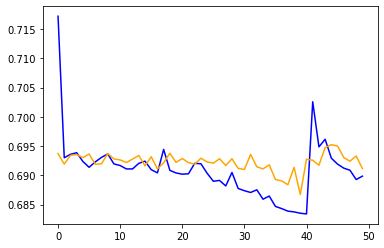

In [ ]:
plt.plot(loss_history,color='blue')
plt.plot(val_loss_hist, color='orange')

In [ ]:


def predict(model,train_loader):
    
    metric_y_val = metric_p_val = None
    model
        
    for i_step, (x, y) in enumerate(train_loader):
                
                x_gpu = x.to(device=device)
                y_gpu = y.to(device=device)
                
                prediction = model(x_gpu)
                _, preds = torch.max(prediction, 1)
                                
                metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                metric_p = preds.cpu().numpy()
                 
    return metric_y, metric_p

In [ ]:
pred=test_data.sample()
pred.to_csv('predict.csv')
brain_predict = BratsDataset(csv_file = 'predict.csv',root_dir = root_dir,types_file = types_file[1],transform=transform)
predict_loader= torch.utils.data.DataLoader(brain_predict, batch_size=1,shuffle=True)

In [ ]:
pred

,Grade,BraTS_2019_subject_ID
247,HGG,BraTS19_TCIA08_162_1


In [ ]:
metric_y_pred, metric_p_pred=predict(model, predict_loader)

In [ ]:
print(metric_y_pred)
print(metric_p_pred)

[0]
[0]


In [ ]:
print("Accuracy {}".format(accuracy_score(metric_y_pred, metric_p_pred))) #hgg==0 lgg==1

Accuracy 0.0
